### Instructions

Please submit your code (preferably in Python and with a github repo or a link to your source code, with .git folder) and also answer the following questions:


**Tell us how you validate your model, which, and why you chose such evaluation technique(s).**

Placeholder

**What is AUC? Why do you think AUC was used as the evaluation metric for such a problem? What are other metrics that you think would also be suitable for this competition?**

Placeholder

**What insight(s) do you have from your model? What is your preliminary analysis of the given dataset?**

Placeholder

**Can you get into the top 100 of the private leaderboard, or even higher?**

Yes, my private score of 0.86767 would have given me 69th position.

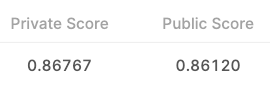

### Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline
pd.set_option('max_colwidth', None)

In [2]:
# Field descriptions for reference
pd.read_excel("data/Data Dictionary.xls", header=1)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [3]:
train = pd.read_csv("data/cs-training.csv")
test = pd.read_csv("data/cs-test.csv")

# Rename columns as they're way too long
col_mapping = columns={
    "Unnamed: 0": "Id",
    "SeriousDlqin2yrs": "target",
    "RevolvingUtilizationOfUnsecuredLines": "credit_bal",
    "NumberOfTime30-59DaysPastDueNotWorse": "30to59_late",
    "NumberOfOpenCreditLinesAndLoans": "n_lines",
    "NumberOfTimes90DaysLate": "90_late",
    "NumberRealEstateLoansOrLines": "n_realestate_lines",
    "NumberOfTime60-89DaysPastDueNotWorse": "60to89_late",
    "NumberOfDependents": "n_dependents",
    "MonthlyIncome": "income"
}

train.rename(columns=col_mapping, inplace=True)
test.rename(columns=col_mapping, inplace=True)
test.drop(columns=["target"], inplace=True)

### EDA

Observations based on `.describe()` and `.info()`

1. `credit_bal` max seems very high
2. Min `age` is 0
3. Max `DebtRatio` extraordinarily high
4. Null values in `income` and `n_dependents` in both train and test

In [4]:
train.describe()

,Id,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  150000 non-null  int64  
 1   target              150000 non-null  int64  
 2   credit_bal          150000 non-null  float64
 3   age                 150000 non-null  int64  
 4   30to59_late         150000 non-null  int64  
 5   DebtRatio           150000 non-null  float64
 6   income              120269 non-null  float64
 7   n_lines             150000 non-null  int64  
 8   90_late             150000 non-null  int64  
 9   n_realestate_lines  150000 non-null  int64  
 10  60to89_late         150000 non-null  int64  
 11  n_dependents        146076 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  101503 non-null  int64  
 1   credit_bal          101503 non-null  float64
 2   age                 101503 non-null  int64  
 3   30to59_late         101503 non-null  int64  
 4   DebtRatio           101503 non-null  float64
 5   income              81400 non-null   float64
 6   n_lines             101503 non-null  int64  
 7   90_late             101503 non-null  int64  
 8   n_realestate_lines  101503 non-null  int64  
 9   60to89_late         101503 non-null  int64  
 10  n_dependents        98877 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 8.5 MB


In [7]:
train.head()

,Id,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
# Deep dive into `DebtRatio` - some extraordinarily high values
# It seems that people with debt but zero income (or NaN) income will yield very large
# `DebtRatio` because the denominator is zero (or some very small number)
# It might make sense to threshold off at a certain value for `DebtRatio`
train.query("DebtRatio > 30000")

,Id,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
4854,4855,0,0.000000,56,0,168835.0,NaN,10,0,3,0,2.0
7513,7514,0,0.152293,71,0,110952.0,NaN,9,0,0,0,0.0
27188,27189,0,0.847176,54,0,40385.0,NaN,18,0,0,0,0.0
36600,36601,0,0.001782,65,0,326442.0,NaN,6,0,1,0,0.0
36666,36667,0,0.616924,40,0,43843.0,NaN,14,0,1,0,0.0
39444,39445,0,0.000000,58,0,33448.0,NaN,28,0,4,0,0.0
46102,46103,0,0.003928,76,0,52112.0,NaN,27,0,23,0,0.0
46404,46405,1,0.338631,42,0,38793.0,NaN,14,0,4,0,1.0
53682,53683,0,1.000000,89,0,61106.5,1.0,2,0,0,0,0.0
58900,58901,0,0.182640,37,0,220516.0,NaN,8,0,3,0,NaN


In [9]:
# Analysing null values in `income`
print(f"There are {train.income.isnull().sum() + train[train.income == 0].shape[0]} "
      "people with zero or null income.")
no_income = train[(train.income.isnull()) | (train.income == 0)]
no_income.query("DebtRatio > 50")

There are 31365 people with zero or null income.


,Id,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
6,7,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
14,15,0,0.019657,76,0,477.0,0.0,6,0,1,0,0.0
16,17,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,33,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
41,42,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149975,149976,0,0.022088,58,0,2716.0,NaN,8,0,2,0,0.0
149976,149977,0,0.000627,76,0,60.0,NaN,5,0,0,0,0.0
149977,149978,0,0.236450,29,0,349.0,NaN,3,0,0,0,0.0
149992,149993,0,0.871976,50,0,4132.0,NaN,11,0,1,0,3.0


In [10]:
with_income = train[~((train.income.isnull()) | (train.income == 0))]

In [11]:
# There are many people with income == 1
train.query('income > 0 & income < 50').income.value_counts()

1.0     605
2.0       6
40.0      3
27.0      2
5.0       2
4.0       2
10.0      2
7.0       1
15.0      1
34.0      1
11.0      1
9.0       1
42.0      1
25.0      1
21.0      1
Name: income, dtype: int64

In [12]:
# People with positive income have very high `DebtRatio` because their income is extremely low
# but have substantial debt -> It would probably make sense to use either `DebtRatio` OR `income`
# instead of both
DR_threshold = 20
print(f"There are {with_income.shape[0]} people with positive income, of which "
      f"{with_income.query('DebtRatio > @DR_threshold').shape[0]} have debt ratio greater than {DR_threshold}")
with_income.query('DebtRatio > @DR_threshold')

There are 118635 people with positive income, of which 569 have debt ratio greater than 20


,Id,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
44,45,0,0.368876,68,0,1687.50000,1.0,31,0,1,0,0.0
167,168,0,0.020966,29,0,639.50000,1.0,3,0,1,0,2.0
195,196,1,0.025892,38,0,74.50000,1.0,13,0,0,0,2.0
217,218,0,0.222696,42,0,800.00000,1.0,3,0,1,0,2.0
400,401,0,0.134192,63,0,926.50000,1.0,9,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149381,149382,0,0.094997,57,0,262.50000,1.0,6,0,0,0,0.0
149462,149463,0,0.006095,51,0,1450.50000,1.0,6,0,2,0,1.0
149494,149495,0,1.000000,50,3,244.50000,1.0,0,0,0,0,0.0
149882,149883,0,0.062398,77,0,714.50000,1.0,3,0,0,0,0.0


In [13]:
# Analysing null values in `n_dependents`
# It is hard to deduce why these values might be NaN, might impute with mode
train[train.n_dependents.isnull()]

,Id,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
8,9,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
96,97,0,0.542243,48,2,10.0,NaN,2,0,0,0,NaN
109,110,0,0.041258,61,0,4739.0,NaN,11,0,4,0,NaN
159,160,0,0.000000,63,0,2.0,NaN,4,0,0,0,NaN
238,239,0,1.000000,28,0,0.0,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149826,149827,0,0.027319,71,0,1419.0,NaN,13,0,1,0,NaN
149854,149855,0,0.056589,75,0,8.0,NaN,3,0,0,0,NaN
149894,149895,0,0.017904,55,0,1058.0,NaN,8,0,1,1,NaN
149948,149949,0,0.055530,27,0,10.0,NaN,1,0,0,0,NaN


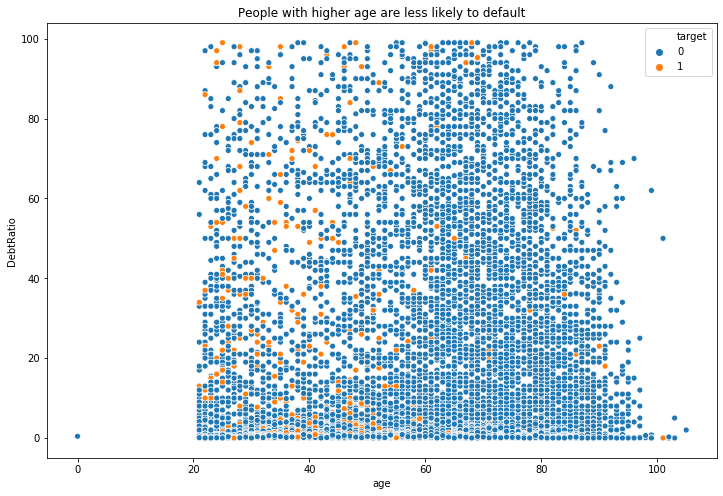

In [14]:
# Hypothesis 1: People with higher age are less likely to default
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='DebtRatio', hue='target', data=train.query("DebtRatio < 100"))
plt.title("People with higher age are less likely to default")
plt.show()

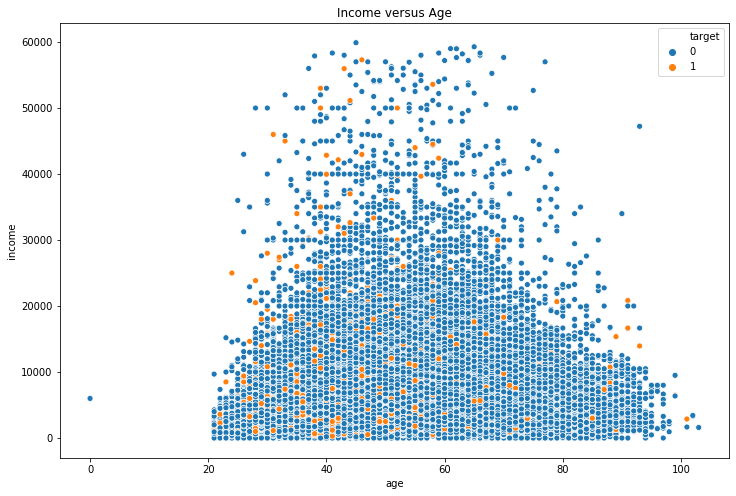

In [15]:
# Hypothesis 2: People with higher age are less likely to default
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='income', hue='target', data=train.query("DebtRatio < 100 & income < 60000"))
plt.title("Income versus Age")
plt.show()

### Data Preprocessing

In [16]:
# Based on above analysis, we will impute the null values with 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
train["income"] = imputer.fit_transform(train["income"].values.reshape(-1, 1))
test["income"] = imputer.fit_transform(test["income"].values.reshape(-1, 1))

train["n_dependents"] = imputer.fit_transform(train["n_dependents"].values.reshape(-1, 1))
test["n_dependents"] = imputer.fit_transform(test["n_dependents"].values.reshape(-1, 1))

In [17]:
# We will replace age == 0 with the median age
# Minimal impact as there is only 1 row with age == 0
median_age = train.age.median()
train["age"] = train["age"].apply(lambda x: x if x > 0 else median_age)
test["age"] = test["age"].apply(lambda x: x if x > 0 else median_age)

In [18]:
# We will truncate off the high `DebtRatio` as anomalies may make some difference
# if we use models like LogisticRegression
train["DebtRatio"] = train["DebtRatio"].apply(lambda x: x if x < 100 else 100)
test["DebtRatio"] = test["DebtRatio"].apply(lambda x: x if x < 100 else 100)

### Feature Engineering

In [19]:
# Feature 1: is_late (bool)
# Y/N to indicate if an individual has had a historical late payment
train["is_late"] = ((train["30to59_late"] > 0) | (train["60to89_late"] > 0) | (train["90_late"] > 0)).astype(int)
test["is_late"] = ((test["30to59_late"] > 0) | (test["60to89_late"] > 0) | (test["90_late"] > 0)).astype(int)

In [20]:
# Feature 2: exceed_limit (bool)
# Y/N to indiciate if an individual has drawn down greater than his/her sum of credit limits
train["exceed_limit"] = (train["credit_bal"] > 1.0).astype(int)
test["exceed_limit"] = (test["credit_bal"] > 1.0).astype(int)

In [21]:
# Feature 3: total no of lines (credit + real estate) --> did not perform better (EXCLUDE)
# train["total_lines"] = train["n_lines"] + train["n_realestate_lines"]
# test["total_lines"] = test["n_lines"] + test["n_realestate_lines"]

In [22]:
# Feature 4: 
train["dr"] = (train["DebtRatio"] > 0.5).astype(int)
test["dr"] = (test["DebtRatio"] > 0.5).astype(int)

In [23]:
# Feature 5: is_retired
# Since no country is stated in the question, we use 65 as the average global retirement age
# based on the OECD data
train["is_retired"] = ((train["income"] < 50) & (train["age"] >= 65)).astype(int)
test["is_retired"] = ((test["income"] < 50) & (test["age"] >= 65)).astype(int)

In [24]:
# Feature 6: is_young
# Younger people tend to have higher default rates
train["is_young"] = ((train["income"] < 50) & (train["age"] < 30)).astype(int)
test["is_young"] = ((test["income"] < 50) & (test["age"] < 30)).astype(int)

### Modelling

In [25]:
# Drop columns not used in modelling
train.drop(columns=["Id", "income"], inplace=True)

In [26]:
def get_preds_for_submission(clf, X, test):
    y_preds = clf.predict_proba(X)[:, 1]
    
    preds = pd.DataFrame({
        "Id": test.Id,
        "Probability": y_preds
    })
    
    preds.to_csv("submission.csv", index=False)

In [27]:
# Train test split our training data
X = train.iloc[:, 1:]
y = train.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Using Logistic Regression

In [28]:
lr = LogisticRegression()

In [29]:
# Feature scaling
cols_to_scale = ["DebtRatio", "n_lines", "n_realestate_lines", "n_dependents", "30to59_late",
                 "60to89_late", "90_late", "age", "credit_bal"]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
test_scaled = test.copy()

for feature in cols_to_scale:
    X_train_scaled[feature] = minmax_scale(X_train_scaled[feature])
    X_test_scaled[feature] = minmax_scale(X_test_scaled[feature])
    test_scaled[feature] = minmax_scale(test_scaled[feature])

In [30]:
lr.fit(X_train_scaled, y_train)
y_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.8158497844188475

#### Using sklearn's Random Forest

In [31]:
clf = RandomForestClassifier(n_estimators=500, max_depth=15)
clf.fit(X_train_scaled, y_train)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.8552374922952606

#### Using XGBoost

In [32]:
# After hyperparameter tuning -> this model is used for final prediction
xgb_clf = XGBClassifier(max_depth=4, n_estimators=150, min_child_weight=5,
                        subsample=0.8, colsample_bytree=0.7, gamma=2)
xgb_clf.fit(X_train, y_train)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)
# print(f"{i}: {roc_auc_score(y_test, y_pred_proba)}")

0.8668879285435958

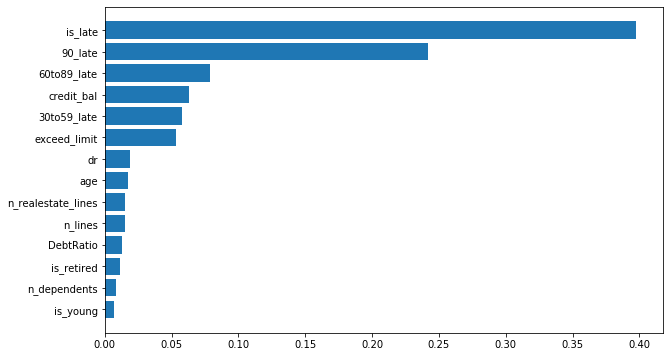

In [55]:
# Plot feature importance
feature_imp = dict(zip(X_train.columns, xgb_clf.feature_importances_))
feature_imp = {k: v for k, v in sorted(feature_imp.items(), key=lambda item: item[1])}

plt.figure(figsize=(10, 6))
plt.barh(list(feature_imp.keys()), list(feature_imp.values()))
plt.show()

In [33]:
get_preds_for_submission(xgb_clf, test.drop(columns=["Id", "income"]), test)

#### Emsembling

Ensembling did not improve overall performance

In [34]:
voting_clf = VotingClassifier (
        estimators = [('xgb', xgb_clf), ('lr', lr), ('rf', clf)],
                     voting='soft', weights = [0.50, 0.17, 0.33])
    
voting_clf.fit(X_train_scaled, y_train)
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.8605345582489607

In [35]:
# get_preds_for_submission(voting_clf, test_scaled.drop(columns=["Id", "income"]), test_scaled)